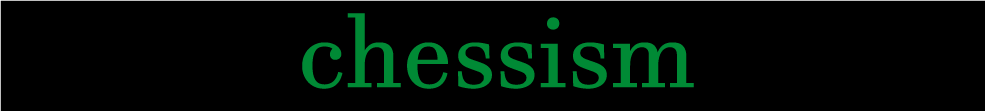

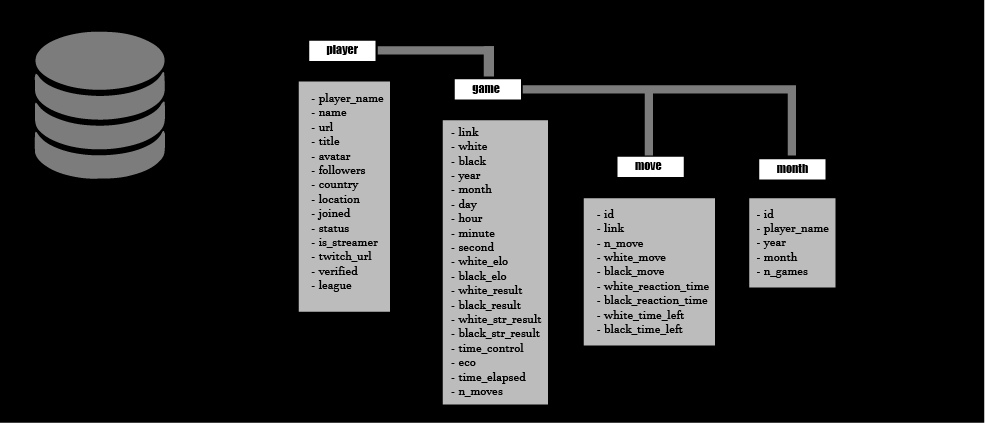

### Unescapable imports:  
( for this test in this notebook,  
you will need other modules not especified here for the whole process)

In [57]:
import time
import pprint
from IPython.display import clear_output
from database.operations.games import create_games
from database.database.engine import init_db
from database.database.db_interface import DBInterface
from database.database.ask_db import (open_request,
                                    delete_all_main_tables,
                                    )

### Checking your .env file

In [63]:
from constants import *
try:
    print('####')
    print('--- .env file is being loaded ---')
    print('USER: ',USER)
    print('PASSWORD: ',PASSWORD)
    print('HOST: ', HOST)
    print('PORT: ', PORT)
    print('DATABASE: ', DATABASE_NAME)
    print('---           OK              ---')
    print('####')
except Exception as e:
    print(f'YOUR .ENV IS NOT BEING LOADED {e}')

####
--- .env file is being loaded ---
USER:  jon
PASSWORD:  3214
HOST:  localhost
PORT:  5432
DATABASE:  chessism
---           OK              ---
####


### Checking your connection to the DB:

In [66]:
try:
    print('####')
    print('--- Connection to the DB done ---')
    await init_db(CONN_STRING)
    DBInterface.initialize_engine_and_session(CONN_STRING)
    print('---            OK             ---')
    print('####')
except Exception as e:
    print(f'YOUR DB is not there or something idk: {e}')

####
--- Connection to the DB done ---
Database 'chessism' already exists.
Ensuring database tables exist...
Database tables checked/created.
Database initialization complete.
DBInterface: Engine already initialized, skipping.
---            OK             ---
####


# In case you need to reset your tables:
#####    It will only delete the tables in this api: player, game, move, month  

In [2]:
#await delete_all_main_tables(CONN_STRING)

## Ask for a players profile:

In [8]:
player_name = "Jospem".lower()

In [9]:
from database.operations.players import insert_player
print('#########')
player_profile = await insert_player({"player_name":player_name})
print('#########')

{'player_name': 'jospem',
 'name': 'Jose Martinez',
 'url': 'https://www.chess.com/member/Jospem',
 'title': 'GM',
 'avatar': 'https://images.chesscomfiles.com/uploads/v1/user/26867272.ae9f1c80.200x200o.8b42d2759267.jpg',
 'followers': 30510,
 'country': 'MX',
 'location': 'Puebla',
 'joined': 1456152005,
 'status': 'premium',
 'is_streamer': True,
 'twitch_url': 'https://twitch.tv/gmjospemm',
 'verified': False,
 'league': 'Legend'}
Attempting to insert new player profile for: jospem
Updating jospem.


##### * A game can not be inserted if both players are not already at the db
##### * That means this insert_player function happens automaticly when asking for games

# Creating games pipeline

### Step 1
#### Calculate the number of months the player has been a member of chess.com
#####  Filter the months that are already at the db
#####  Return the months that we want to download

In [15]:
from database.operations.available_months import just_new_months
new_months = await just_new_months(player_name)
clear_output()
print('#########')
pprint.pp(new_months[:4])
print('#########')

['2016-02', '2016-03', '2016-04', '2016-05']


### Step 2
Download every one of the months.  
To comply with chess.com's requirements only 2 concurrent threads are used 

In [16]:
from database.operations.chess_com_api import download_months
print('#########')
downloaded_games_by_month = await download_months(player_name, new_months)
print('#########')

Starting download of 113 months with 2 concurrent requests...
Finished downloading 113 months in 95.08 seconds.


The object: downloaded_games_by_month is a dictionary

In [30]:
years = list(downloaded_games_by_month.keys())
months = list(downloaded_games_by_month[years[0]].keys())
n_games_for_first_month = len(downloaded_games_by_month[years[0]][months[0]])
print('#########')
print(f'Years recorded for: {player_name}')
pprint.pp(years)
print(f'Months recorded for: {player_name}')
pprint.pp(months)
print(f'Number of games in year {years[0]}-{months[0]}: {n_games_for_first_month}')
print('#########')

Years recorded for: jospem
[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Months recorded for: jospem
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of games in year 2016-2: 5


Each game is a dictionary too:

In [39]:
print('#########\n')
pprint.pp(downloaded_games_by_month[years[0]][months[0]][0])
print('#########\n')

#########

{'url': 'https://www.chess.com/game/live/1471639535',
 'pgn': '[Event "Live Chess"]\n'
        '[Site "Chess.com"]\n'
        '[Date "2016.02.22"]\n'
        '[Round "-"]\n'
        '[White "Jospem"]\n'
        '[Black "danioptima"]\n'
        '[Result "1-0"]\n'
        '[CurrentPosition "r1b1k2r/pppp1pp1/2n4p/4P3/3P2Q1/2PBB3/PP3PPP/RN2K2R '
        'b KQkq -"]\n'
        '[Timezone "UTC"]\n'
        '[ECO "C40"]\n'
        '[ECOUrl '
        '"https://www.chess.com/openings/Kings-Pawn-Opening-Kings-Knight-Variation"]\n'
        '[UTCDate "2016.02.22"]\n'
        '[UTCTime "14:40:34"]\n'
        '[WhiteElo "1363"]\n'
        '[BlackElo "1179"]\n'
        '[TimeControl "180"]\n'
        '[Termination "Jospem won by resignation"]\n'
        '[StartTime "14:40:34"]\n'
        '[EndDate "2016.02.22"]\n'
        '[EndTime "14:42:11"]\n'
        '[Link "https://www.chess.com/game/live/1471639535"]\n'
        '\n'
        '1. e4 {[%clk 0:03:00]} 1... e5 {[%clk 0:02:54]} 2. Nf3 {[%c

### This raw PGN has to be formatted for the database:

In [34]:
from database.operations.format_games import format_games
print('#########')
formatted_games = await format_games(downloaded_games_by_month, player_name)
print('#########')

#########
Filtered 50706 new games in: 0.44 seconds
$$$$$$$$$$$$$$$$$$$$$$
unique_player done in:  0.020131826400756836
unique players  7588
$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$
Successfully performed bulk insert for 3131 items in Player.
3131 unique players inserted in DB in: 0.35 seconds
Formatted 50706 games in 73.10713982582092
#########


###
Trying to insert an Item that is already at the DB will broke the pipeline.  
The: **Filtered new games**, and the **unique_player**,  
mesures how much time it takes to make that arragement.  

  The new formatted games are ready to be inserted to the DB,  
  They are dicts too:

In [36]:
pprint.pp(formatted_games[0])

{'link': 1471639535,
 'time_control': '180',
 'year': 2016,
 'month': 2,
 'day': 22,
 'hour': 14,
 'minute': 40,
 'second': 34,
 'end_year': 2016,
 'end_month': 2,
 'end_day': 22,
 'end_hour': 14,
 'end_minute': 42,
 'end_second': 11,
 'time_elapsed': 97.0,
 'black': 'danioptima',
 'black_elo': 1179,
 'black_str_result': 'resigned',
 'black_result': 0.0,
 'white': 'jospem',
 'white_elo': 1363,
 'white_str_result': 'win',
 'white_result': 1.0,
 'n_moves': 12,
 'moves_data': {'link': 1471639535,
                'white_moves': ['e4',
                                'Nf3',
                                'Nxe5',
                                'Nf3',
                                'c3',
                                'd4',
                                'Bd3',
                                'e5',
                                'Nxg5',
                                'Bxg5',
                                'Qxg4',
                                'Be3'],
                'white_reaction_

### Step 3:  
Now this formatted games can be separated to insert games, moves from every game and the months of games we have for the player_name:

In [41]:
from database.operations.format_games import insert_games_months_moves_and_players
print('#########')
await insert_games_months_moves_and_players(formatted_games, player_name)
print('#########')

#########
50353 Games ready to insert
2310910 Moves ready to insert
Time elapsed: 27.90225315093994
Formatted 50353 games and 2310910 moves in: 27.90 seconds
Successfully performed bulk insert for 50353 items in Game.
Successfully inserted 50353 games.
Successfully performed bulk insert for 2310910 items in Move.
Successfully inserted 2310910 moves.
Successfully performed bulk insert for 104 items in Month.
Successfully inserted 104 months.
Overall database insertion completed for 50353 games, 2310910 moves, and 104 months.
Inserted games, moves, and months for 50353 games in: 152.82 seconds
Total time for processing this batch of formatted games: 152.82 seconds
#########


# The DB:
### 1.- Size:

In [42]:
db_size_query = "SELECT pg_database_size(current_database()) / (1024.0 * 1024.0 * 1024.0) AS database_size_gb;"
db_size_result = await open_request(db_size_query, fetch_as_dict=True)

if db_size_result:
    # The result will be a list of dictionaries, like [{'database_size_gb': 0.123}]
    database_size_gb = db_size_result[0]['database_size_gb']
    print(f"Current database size: {database_size_gb:.2f} GB")
else:
    print("Could not retrieve database size.")

Current database size: 2.18 GB


### 2.- Players:

In [47]:
players_updated_query = "SELECT COUNT(*) AS players_already_updated FROM player WHERE name IS NOT NULL;"
players_updated_result = await open_request(players_updated_query, fetch_as_dict=True)

if players_updated_result:
    updated_count = players_updated_result[0]['players_already_updated']
    print(f"Number of players with all their games in: {updated_count:,}")
else:
    print("Could not retrieve the count for players already updated.")

players_to_update_query = "SELECT COUNT(*) AS players_needing_update FROM player WHERE name IS NULL;"
players_to_update_result = await open_request(players_to_update_query, fetch_as_dict=True)

if players_to_update_result:
    needs_update_count = players_to_update_result[0]['players_needing_update']
    print(f"Number of players that played in the games we ask : {needs_update_count:,}")
else:
    print("Could not retrieve the count for players needing an update.")

Number of players with all their games in: 17
Number of players that played in the games we ask : 68,202


### 3.- Games and Moves:

In [48]:
total_games_query = "SELECT COUNT(*) AS total_games FROM game;"
total_games_result = await open_request(total_games_query, fetch_as_dict=True)
if total_games_result:
    games_count = total_games_result[0]['total_games']
    print(f"Total number of games in the database: {games_count:,}")
else:
    print("Could not retrieve the total number of games.")
total_moves_query = "SELECT COUNT(*) AS total_moves FROM moves;"
total_moves_result = await open_request(total_moves_query, fetch_as_dict=True)

if total_moves_result:
    moves_count = total_moves_result[0]['total_moves']
    print(f"Total number of moves in the database: {moves_count:,}")
else:
    print("Could not retrieve the total number of moves.")

Total number of games in the database: 455,205
Total number of moves in the database: 19,097,690


### 4 .- Models

In [54]:
get_tables_query = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';"
tables_result = await open_request(get_tables_query, fetch_as_dict=True)
if tables_result:
    print("Models:")
    for table_row in tables_result:
        # exclude the tables of other apis
        if table_row['table_name'] in ['player','game','moves','months']:
            table_name = table_row['table_name']
            print(f"\n- Table: {table_name}")
    
            # Query to retrieve column names for the current table
            get_columns_query = f"SELECT column_name FROM information_schema.columns WHERE table_schema = 'public' AND table_name = '{table_name}';"
    
            # Execute the column query
            columns_result = await open_request(get_columns_query, fetch_as_dict=True)
    
            if columns_result:
                print("  Columns:")
                for column_row in columns_result:
                    print(f"    - {column_row['column_name']}")
            else:
                print(f"  Could not retrieve column names for table '{table_name}'.")
else:
    print("Could not retrieve table names from the database or no tables found.")

Models:

- Table: player
  Columns:
    - player_name
    - name
    - url
    - title
    - avatar
    - followers
    - country
    - location
    - joined
    - status
    - is_streamer
    - twitch_url
    - verified
    - league

- Table: game
  Columns:
    - link
    - white
    - black
    - year
    - month
    - day
    - hour
    - minute
    - second
    - white_elo
    - black_elo
    - white_result
    - black_result
    - white_str_result
    - black_str_result
    - time_control
    - eco
    - time_elapsed
    - n_moves

- Table: months
  Columns:
    - id
    - player_name
    - year
    - month
    - n_games

- Table: moves
  Columns:
    - id
    - link
    - n_move
    - white_move
    - black_move
    - white_reaction_time
    - black_reaction_time
    - white_time_left
    - black_time_left
